In [1]:
###Importing the modules###

import numpy as np
import xarray as xr
import math as mt
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
from matplotlib.cm import get_cmap
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as patches
import matplotlib.patheffects as path_effects
import glob
from metpy.plots import USCOUNTIES
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature
import metpy.calc as mpcalc
from metpy.units import units
from scipy import stats
from collections import Counter
import cftime
import csv
import re

print("Done importing modules")

Done importing modules


In [2]:
###Import the dataset and the binary T52 mask###

# CF_df_All = xr.open_dataset('/projects/zami4053/Synoptic_Research/Netcdf_CF/CF_xr_723.nc')
# binmask = xr.open_dataset('/projects/zami4053/Synoptic_Research/Netcdf_CF/binary_mask_T52.nc')
# CF_df_LP = xr.open_dataset('/projects/zami4053/Synoptic_Research/Netcdf_CF/CF_xr_LP145.nc')
# CF_df_HP = xr.open_dataset('/projects/zami4053/Synoptic_Research/Netcdf_CF/CF_xr_HP145.nc')
df_All = pd.read_csv('/projects/zami4053/Synoptic_Research/CSV_DFs/CF_All_Precip.csv')
df_HP = pd.read_csv('/projects/zami4053/Synoptic_Research/CSV_DFs/CF_High_Precip.csv')
df_LP = pd.read_csv('/projects/zami4053/Synoptic_Research/CSV_DFs/CF_Low_Precip.csv')

#df_All
#Select a datset to use#
#CF_df = CF_df_All.copy()   #can change this
df_All

,date,max_value,max_time,file_date,total_precip
0,1950-01-04,12449.629923,1950-01-03 09:00:00,1950-01-04,328.730494
1,1950-01-30,10615.853132,1950-01-29 06:00:00,1950-01-30,87.406158
2,1950-02-22,1695.041284,1950-02-21 16:00:00,1950-02-22,319.826066
3,1950-03-01,2258.049045,1950-02-28 07:00:00,1950-03-01,393.072784
4,1950-03-08,2873.386661,1950-03-06 22:00:00,1950-03-08,117.258295
...,...,...,...,...,...
718,2022-09-22,5556.971814,2022-09-21 16:00:00,2022-09-22,759.445786
719,2022-11-11,907.817141,2022-11-10 03:00:00,2022-11-11,34.525026
720,2022-11-30,316.819875,2022-11-29 05:00:00,2022-11-30,467.350841
721,2022-12-14,1187.444094,2022-12-13 18:00:00,2022-12-14,1589.295030


In [4]:
###Rewrite the txt file as a csv and open it###

# #Open the text file for reading#
# with open('/projects/zami4053/Synoptic_Research/Other_Data/norm.daily.ao.index.b500101.current.ascii.txt', 'r') as textfile:
#     #Open the CSV file for writing#
#     with open('AO.csv', 'w', newline='') as csvfile:
#         csvwriter = csv.writer(csvfile)
#         csvwriter.writerow(['Year', 'Month', 'Day', 'AO_Index'])

#         #Read the text file line by line#
#         for line in textfile:
#             #Strip leading/trailing whitespace and split the line into parts
#             #Adjust the splitting logic to match your text file's format
#             parts = re.split(r'\s+', line.strip())

#             #Write the parts to the CSV file#
#             csvwriter.writerow(parts)

#Read in df#
df_AO_ = pd.read_csv('Other_Data/AO.csv')

#Drop the one -99 value#
df_AO = df_AO_.drop(19477)

#First build a proper datetime column#
df_AO['date'] = pd.to_datetime(df_AO[['Year','Month','Day']])

#Then drop anything after 2022-12-31#
df_AO = df_AO[df_AO['date'] <= '2022-12-31'].reset_index(drop=True)
df_AO

,Year,Month,Day,AO_Index,date
0,1950,1,1,-2.511,1950-01-01
1,1950,1,2,-1.505,1950-01-02
2,1950,1,3,-1.173,1950-01-03
3,1950,1,4,-1.251,1950-01-04
4,1950,1,5,-0.126,1950-01-05
...,...,...,...,...,...
26657,2022,12,27,-0.546,2022-12-27
26658,2022,12,28,-0.228,2022-12-28
26659,2022,12,29,-0.270,2022-12-29
26660,2022,12,30,-0.510,2022-12-30


In [5]:
###Convert date column to datetime###

df_AO['date'] = pd.to_datetime(df_AO['date']).dt.date
df_All['date'] = pd.to_datetime(df_All['date']).dt.date
df_HP['date'] = pd.to_datetime(df_HP['date']).dt.date
df_LP['date'] = pd.to_datetime(df_LP['date']).dt.date

In [6]:
###Merge the datasets###

#“All” fronts#
df_All_AO = df_All.merge(
    df_AO[['date','AO_Index']],
    on='date',
    how='left'
)

#Low-precip fronts#
df_LP_AO = df_LP.merge(
    df_AO[['date','AO_Index']],
    on='date',
    how='left'
)

#High-precip fronts#
df_HP_AO = df_HP.merge(
    df_AO[['date','AO_Index']],
    on='date',
    how='left'
)

#AO data is now attatched to the CF groups#
df_All_AO

,date,max_value,max_time,file_date,total_precip,AO_Index
0,1950-01-04,12449.629923,1950-01-03 09:00:00,1950-01-04,328.730494,-1.251
1,1950-01-30,10615.853132,1950-01-29 06:00:00,1950-01-30,87.406158,0.731
2,1950-02-22,1695.041284,1950-02-21 16:00:00,1950-02-22,319.826066,0.292
3,1950-03-01,2258.049045,1950-02-28 07:00:00,1950-03-01,393.072784,-0.609
4,1950-03-08,2873.386661,1950-03-06 22:00:00,1950-03-08,117.258295,-1.212
...,...,...,...,...,...,...
718,2022-09-22,5556.971814,2022-09-21 16:00:00,2022-09-22,759.445786,0.237
719,2022-11-11,907.817141,2022-11-10 03:00:00,2022-11-11,34.525026,1.781
720,2022-11-30,316.819875,2022-11-29 05:00:00,2022-11-30,467.350841,-1.486
721,2022-12-14,1187.444094,2022-12-13 18:00:00,2022-12-14,1589.295030,-3.198


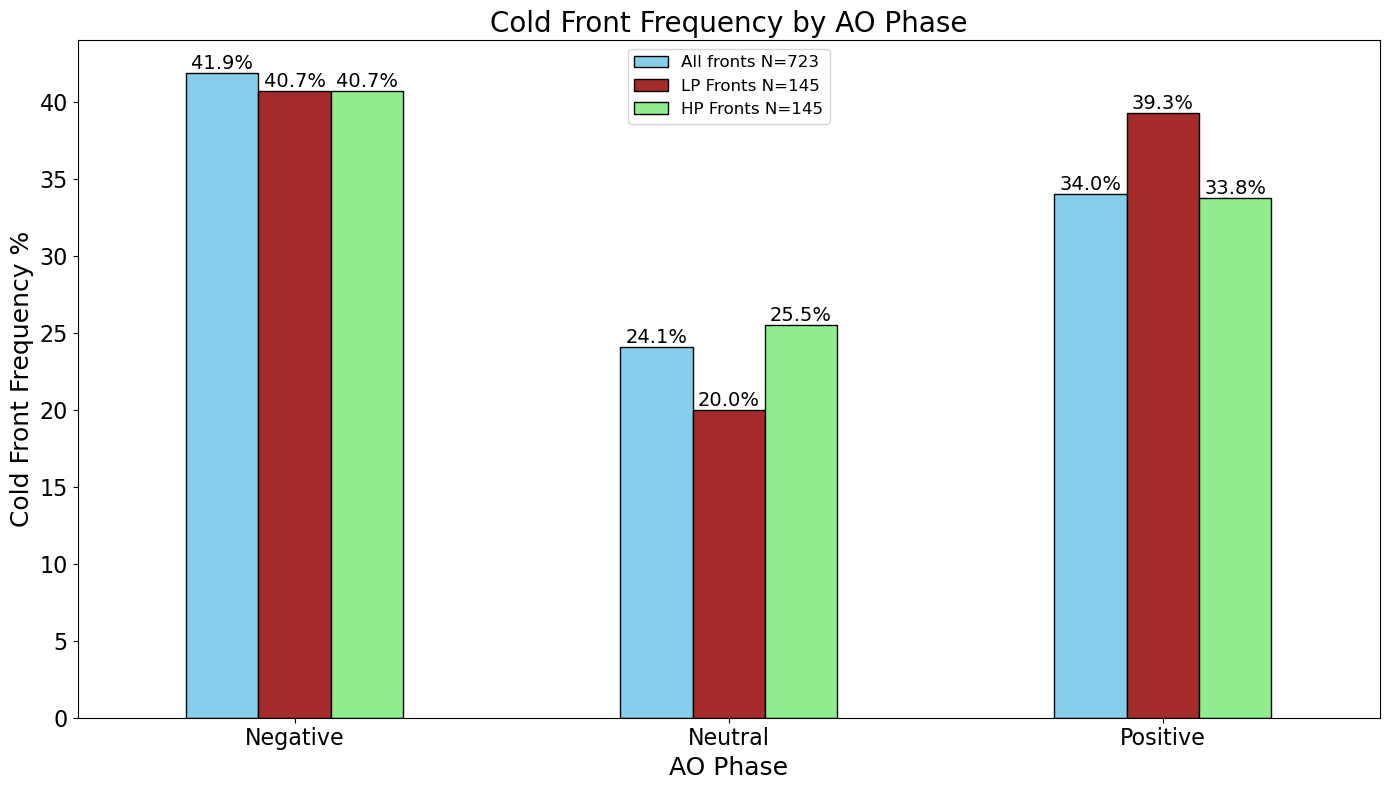

In [7]:
###Plotting the AO data with CF frequency###

#1)Define the phase‐binning#
def ao_phase(x):
    
    if x <= -0.5:   return 'Negative'
    elif x >= 0.5:  return 'Positive'
    else:           return 'Neutral'

#2)Make sure each of your three DF’s has a plain‐date “date” column and an “AO_Index” column#

#3)Bin into phases#
for df in (df_All_AO, df_LP_AO, df_HP_AO):
    df['AO_Phase'] = df['AO_Index'].apply(ao_phase)

#4)Count how many cold fronts fall in each phase#
counts_all = df_All_AO['AO_Phase'].value_counts()
counts_lp  = df_LP_AO ['AO_Phase'].value_counts()
counts_hp  = df_HP_AO ['AO_Phase'].value_counts()

#5)Assemble into a single DataFrame, reindexing to get the phases in right order#
counts = pd.DataFrame({
    'All fronts N=723'     : counts_all,
    'LP Fronts N=145'     : counts_lp,
    'HP Fronts N=145'    : counts_hp
}).reindex(['Negative','Neutral','Positive']).fillna(0).astype(int)

#6)Convert to relative frequencies#
totals = {
    'All fronts N=723'  : len(df_All_AO),
    'LP Fronts N=145'  : len(df_LP_AO),
    'HP Fronts N=145' : len(df_HP_AO)
}
rel_counts = counts.copy()

for col, N in totals.items():
    rel_counts[col] = rel_counts[col] / N * 100


#7)Plotting#
ax = rel_counts.plot(
    kind='bar',
    figsize=(14,8),
    color=['skyblue','brown','lightgreen'],
    edgecolor='k'
)
ax.set_xlabel('AO Phase', fontsize=18)
ax.set_ylabel('Cold Front Frequency %', fontsize=18)
ax.set_title('Cold Front Frequency by AO Phase', fontsize=20)
ax.legend(frameon=True, fontsize=12)
plt.xticks(rotation=0, fontsize=16)
plt.yticks(fontsize=16)

#Label bars %#
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', fontsize=14)

plt.tight_layout()
#plt.savefig("CF_AO_3.png", dpi=150, bbox_inches='tight')

plt.show()

NameError: name 'ci_all' is not defined

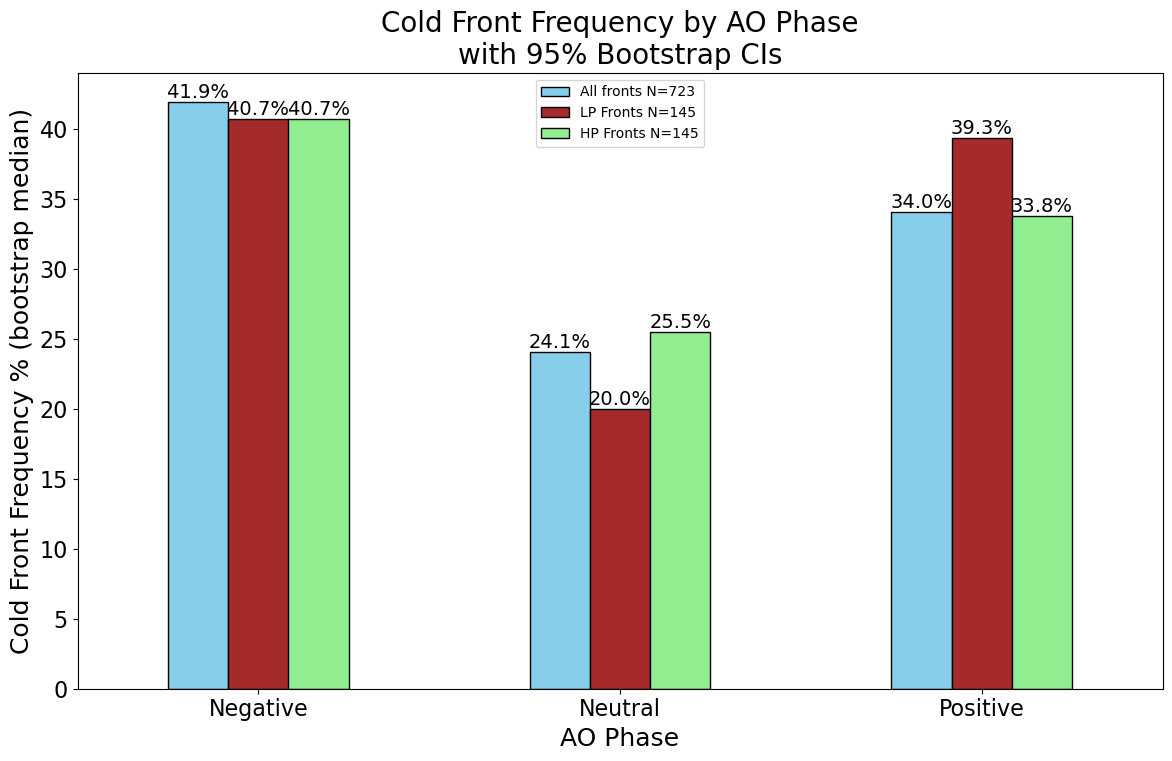

In [8]:
###Try bootstrapping now###

#Gather the AO dataset#
df_AO_full = df_AO.copy()
df_AO_full['AO_Phase'] = df_AO_full['AO_Index'].apply(ao_phase)


def bootstrap_phase_distribution(df_full, N, n_boot=1000, phases=['Negative','Neutral','Positive']):
    """
    Returns an (n_boot × n_phases) array of percent-in-phase values.
    """
    boot = np.zeros((n_boot, len(phases)))
    
    for i in range(n_boot):
        samp = df_full.sample(n=N, replace=True)
        freq = (samp['AO_Phase'].value_counts(normalize=True).reindex(phases, fill_value=0) * 100)
        boot[i,:] = freq.values
        
    return boot


#Sample sizes#
N_all = len(df_All_AO)   # 723
N_lp  = len(df_LP_AO)    # 145
N_hp  = len(df_HP_AO)    # 145

#Bootstrap distributions#
boot_all = bootstrap_phase_distribution(df_AO_full, N_all)
boot_lp  = bootstrap_phase_distribution(df_AO_full, N_lp)
boot_hp  = bootstrap_phase_distribution(df_AO_full, N_hp)

phases = ['Negative','Neutral','Positive']

#Compute medians and 95% CI bounds#
def summarize_boot(boot):
    """
    Returns the low end, median, and upper end for each CI.
    """
    med = np.median(boot, axis=0)
    lower, upper = np.percentile(boot, [5, 95], axis=0)
    
    #Compute error lengths around the median#
    err_lower = med - lower
    err_upper = upper - med
    
    return med, err_lower, err_upper

med_all, low_all, up_all = summarize_boot(boot_all)
med_lp,  low_lp,  up_lp  = summarize_boot(boot_lp)
med_hp,  low_hp,  up_hp  = summarize_boot(boot_hp)

#Plot original data#
ax = rel_counts.plot(
    kind='bar',
    figsize=(14, 8),
    color=['skyblue','brown','lightgreen'],
    edgecolor='k'
)
ax.set_xlabel('AO Phase', fontsize=18)
ax.set_ylabel('Cold Front Frequency % (bootstrap median)', fontsize=18)
ax.set_title('Cold Front Frequency by AO Phase\nwith 95% Bootstrap CIs', fontsize=20)
plt.xticks(rotation=0, fontsize=16)
plt.yticks(fontsize=16)

#Annotate median values#
for cont in ax.containers:
    ax.bar_label(cont, fmt='%.1f%%', fontsize=14)
    
#Pack medians and CI’s together for plotting error bars#
med_ci = [
  (med_all, ci_all),
  (med_lp,  ci_lp),
  (med_hp,  ci_hp)
]

#Plotting the error bars#
for container, (med, ci) in zip(ax.containers, med_ci):
    xs = [bar.get_x() + bar.get_width()/2 for bar in container]
    lower_ci, upper_ci = ci

    #Error lengths around the medians#
    err_lo = med - lower_ci
    err_hi = upper_ci - med
    yerr   = np.vstack([err_lo, err_hi])

    #Start drawing from median#
    ax.errorbar(xs, med, yerr=yerr, fmt='none', capsize=5, color='k')

plt.tight_layout()
#plt.savefig("CF_AO_3_BOOT95.png", dpi=150, bbox_inches='tight')

plt.show()

/tmp/ipykernel_2307745/1088776362.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(phase_order, rotation=0, fontsize=16)


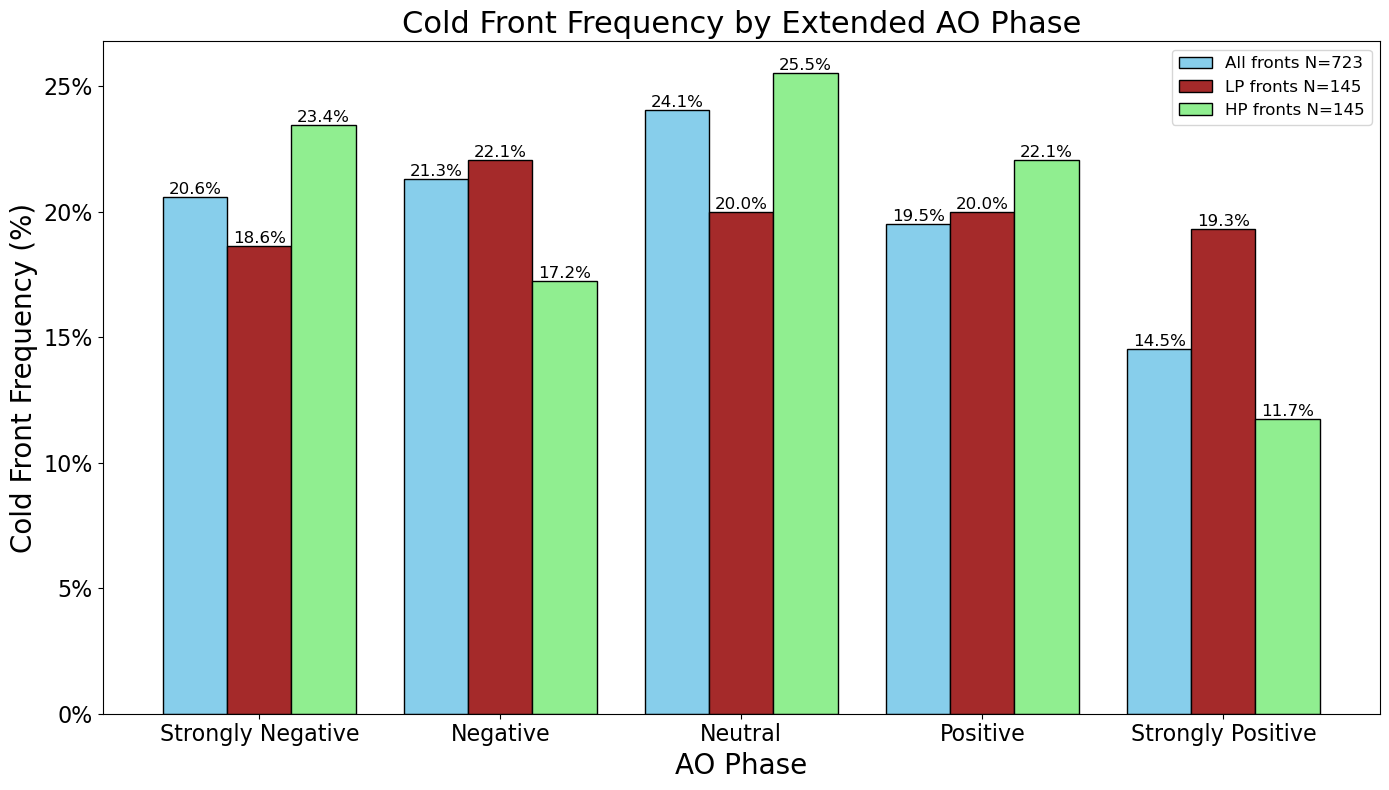

In [9]:
###Plotting the AO data with CF frequency: 5 bins###

#1) New, finer AO‐phase binning#
def ao_phase_ext(x):
    
    if x <= -1.5:
        return 'Strongly Negative'
    elif x <= -0.5:
        return 'Negative'
    elif x < 0.5:
        return 'Neutral'
    elif x < 1.5:
        return 'Positive'
    else:
        return 'Strongly Positive'

#2)Apply to all dfs#
for df in (df_All_AO, df_LP_AO, df_HP_AO):
    df['AO_Phase2'] = df['AO_Index'].apply(ao_phase_ext)

#3)Count & normalize#
phase_order = [
    'Strongly Negative','Negative',
    'Neutral',
    'Positive','Strongly Positive'
]
totals = {
    'All fronts N=723': len(df_All_AO),
    'LP fronts N=145' : len(df_LP_AO),
    'HP fronts N=145' : len(df_HP_AO)
}

#Build a DataFrame of raw counts#
counts2 = pd.DataFrame({
    'All fronts N=723' : df_All_AO['AO_Phase2'].value_counts(),
    'LP fronts N=145'  : df_LP_AO ['AO_Phase2'].value_counts(),
    'HP fronts N=145'  : df_HP_AO ['AO_Phase2'].value_counts(),
}).reindex(phase_order).fillna(0).astype(int)

#Convert to relative frequencies#
rel2 = counts2.copy().astype(float)

for col, N in totals.items():
    rel2[col] = rel2[col] / N * 100  

#4)Plotting#
fig, ax = plt.subplots(figsize=(14,8))
rel2.plot.bar(
    ax=ax,
    width=0.8,
    color=['skyblue','brown','lightgreen'],
    edgecolor='k'
)

ax.set_xlabel('AO Phase', fontsize=20)
ax.set_ylabel('Cold Front Frequency (%)', fontsize=20)
ax.set_title('Cold Front Frequency by Extended AO Phase', fontsize=22)
ax.set_xticklabels(phase_order, rotation=0, fontsize=16)
ax.set_yticklabels(phase_order, rotation=0, fontsize=16)
ax.legend(fontsize=12, title_fontsize=12)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.0f}%"))

#Label bars %#
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', fontsize=12)
    
plt.tight_layout()
#plt.savefig("CF_AO_5.png", dpi=150, bbox_inches='tight')

plt.show()

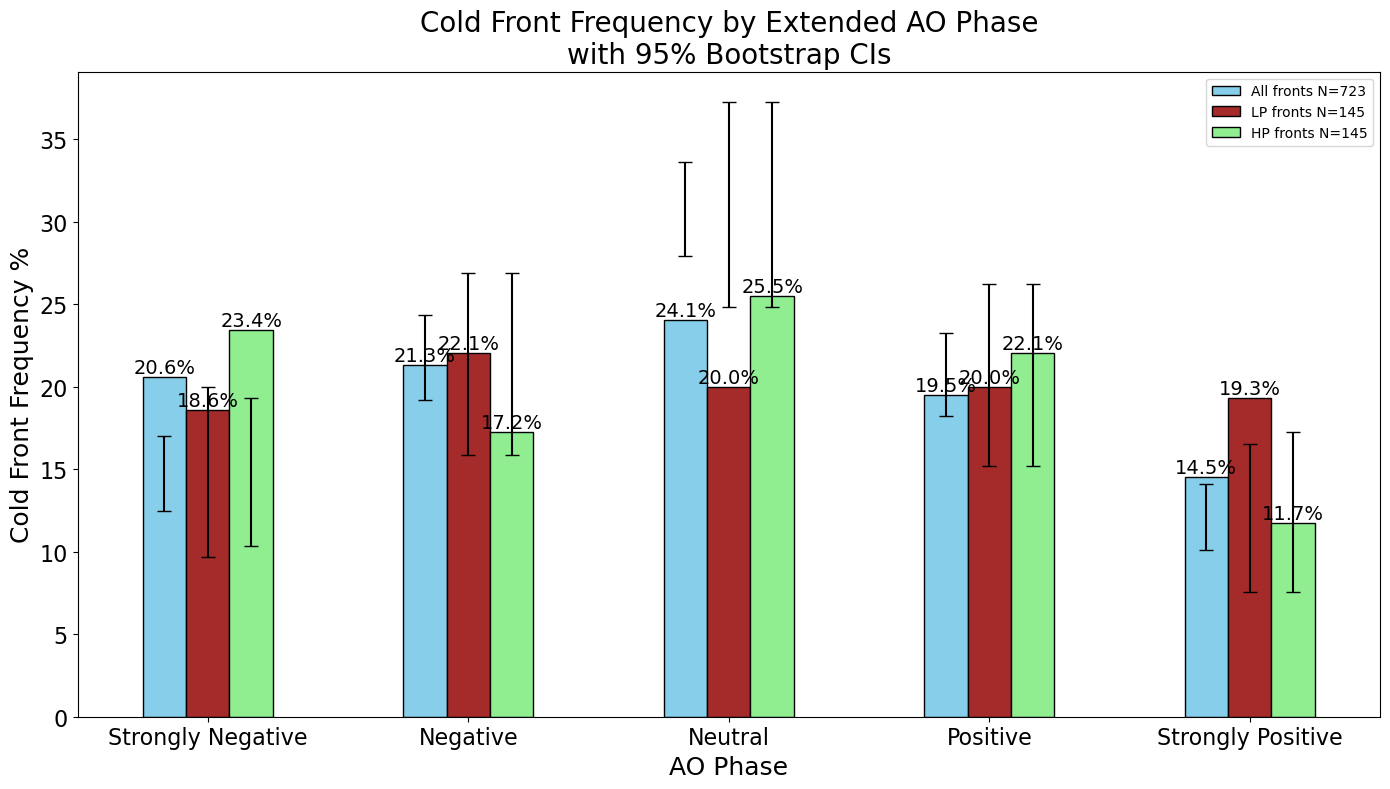

In [10]:
###Now try bootstrapping for 5 bin plot###

# Gather the AO dataset #
df_AO_full = df_AO.copy()
df_AO_full['AO_Phase_Ext'] = df_AO_full['AO_Index'].apply(ao_phase_ext)

def bootstrap_phase_distribution(df_full, N, n_boot=1000,
                                 phases=['Strongly Negative','Negative','Neutral','Positive','Strongly Positive']):
    """
    Returns an (n_boot × n_phases) array of percent-in-phase values.
    """
    boot = np.zeros((n_boot, len(phases)))
    
    for i in range(n_boot):
        
        samp = df_full.sample(n=N, replace=True)
        freq = (samp['AO_Phase_Ext']
                .value_counts(normalize=True)
                .reindex(phases, fill_value=0) * 100)
        boot[i,:] = freq.values
        
    return boot

#Sample sizes#
N_all = len(df_All_AO)   # 723
N_lp  = len(df_LP_AO)    # 145
N_hp  = len(df_HP_AO)    # 145

#Bootstrap distributions#
phases5  = ['Strongly Negative','Negative','Neutral','Positive','Strongly Positive']
boot_all = bootstrap_phase_distribution(df_AO_full, N_all, phases=phases5)
boot_lp  = bootstrap_phase_distribution(df_AO_full, N_lp,  phases=phases5)
boot_hp  = bootstrap_phase_distribution(df_AO_full, N_hp,  phases=phases5)

#Compute medians and 95% CI bounds#
def summarize_boot(boot):
    """
    Returns the median, lower‐error, and upper‐error for each phase’s CI.
    """
    med = np.median(boot, axis=0)
    lower, upper = np.percentile(boot, [5, 95], axis=0)
    err_lower = med - lower
    err_upper = upper - med
    return med, err_lower, err_upper

med_all, low_all, up_all = summarize_boot(boot_all)
med_lp,  low_lp,  up_lp  = summarize_boot(boot_lp)
med_hp,  low_hp,  up_hp  = summarize_boot(boot_hp)

#Plot original data#
ax = rel2.plot(
    kind='bar',
    figsize=(14, 8),
    color=['skyblue','brown','lightgreen'],
    edgecolor='k'
)
ax.set_xlabel('AO Phase', fontsize=18)
ax.set_ylabel('Cold Front Frequency %', fontsize=18)
ax.set_title('Cold Front Frequency by Extended AO Phase\nwith 95% Bootstrap CIs', fontsize=20)
plt.xticks(rotation=0, fontsize=16)
plt.yticks(fontsize=16)

#Annotate median values#
for cont in ax.containers:
    ax.bar_label(cont, fmt='%.1f%%', fontsize=14)
    
#Pack medians and errors for plotting error bars#
med_err = [
    (med_all, low_all, up_all),
    (med_lp,  low_lp,  up_lp),
    (med_hp,  low_hp,  up_hp)
]

#Plotting the error bars#
for container, (med, err_lo, err_hi) in zip(ax.containers, med_err):
    xs   = [bar.get_x() + bar.get_width()/2 for bar in container]
    yerr = np.vstack([err_lo, err_hi])
    ax.errorbar(xs, med, yerr=yerr, fmt='none', capsize=5, color='k')

plt.tight_layout()
#plt.savefig("CF_AO_5_BOOT95.png", dpi=150, bbox_inches='tight')

plt.show()

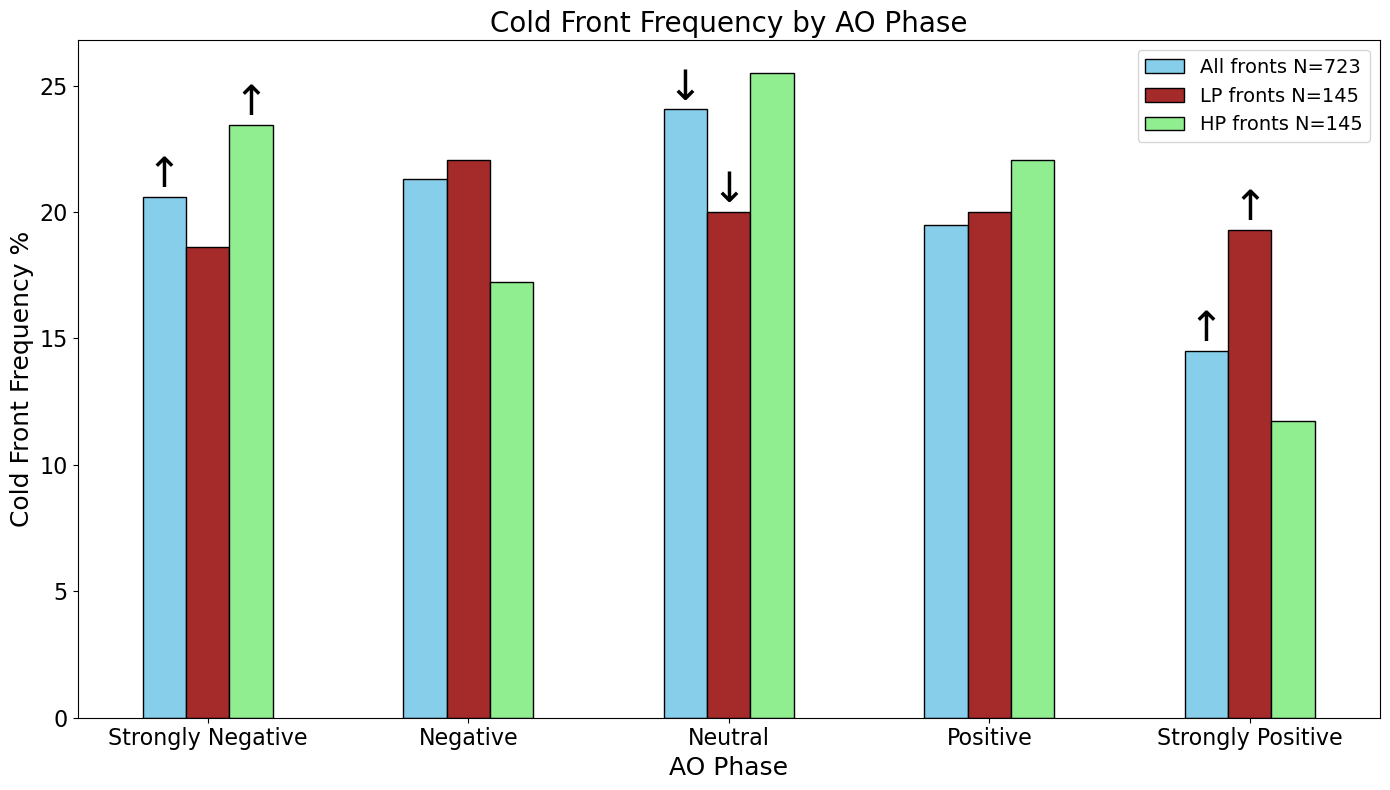

In [30]:
###Make this figure publishable worthy###

#Categories#
phases5 = ['Strongly Negative','Negative','Neutral','Positive','Strongly Positive']
n_boot  = 1000
annotate_groups = ['all', 'lp', 'hp']  # choose any subset from {'all','lp','hp'} to annotate with arrows
alpha_bounds = (5, 95)                 # two-sided 90% interval

#Prep full AO with phase labels#
df_AO_full = df_AO.copy()
df_AO_full['AO_Phase_Ext'] = df_AO_full['AO_Index'].apply(ao_phase_ext)

#Bootstrap utility#
def bootstrap_phase_distribution(df_full, N, n_boot=1000, phases=phases5):
    """
    Returns (n_boot x n_phases) array of percent-in-phase values for samples of size N.
    """
    boot = np.zeros((n_boot, len(phases)))
    
    for i in range(n_boot):
        
        samp = df_full.sample(n=N, replace=True)
        freq = (samp['AO_Phase_Ext']
                .value_counts(normalize=True)
                .reindex(phases, fill_value=0) * 100.0)
        boot[i, :] = freq.values
    
    return boot


def summarize_boot(boot, lo=5, hi=95):
    """
    Returns median and asymmetric errors for plotting error bars.
    """
    med = np.median(boot, axis=0)
    lower, upper = np.percentile(boot, [lo, hi], axis=0)
    err_lower = med - lower
    err_upper = upper - med
    
    return med, err_lower, err_upper, lower, upper


# Sample sizes for each category#
N_all = len(df_All_AO)   #723
N_lp  = len(df_LP_AO)    #145
N_hp  = len(df_HP_AO)    #145

#Bootstrap distributions#
boot_all = bootstrap_phase_distribution(df_AO_full, N_all, n_boot=n_boot, phases=phases5)
boot_lp  = bootstrap_phase_distribution(df_AO_full, N_lp,  n_boot=n_boot, phases=phases5)
boot_hp  = bootstrap_phase_distribution(df_AO_full, N_hp,  n_boot=n_boot, phases=phases5)

##Summaries#
med_all, low_all, up_all, lo_all, hi_all = summarize_boot(boot_all, *alpha_bounds)
med_lp,  low_lp,  up_lp,  lo_lp,  hi_lp  = summarize_boot(boot_lp,  *alpha_bounds)
med_hp,  low_hp,  up_hp,  lo_hp,  hi_hp  = summarize_boot(boot_hp,  *alpha_bounds)

##Plot observed bars#
ax = rel2.plot(
    kind='bar',
    figsize=(14, 8),
    color=['skyblue', 'brown', 'lightgreen'],
    edgecolor='k'
)

ax.set_xlabel('AO Phase', fontsize=18)
ax.set_ylabel('Cold Front Frequency %', fontsize=18)
ax.set_title('Cold Front Frequency by AO Phase', fontsize=20)
plt.xticks(rotation=0, fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=14)

#Significance arrows#
obs_all = rel2.iloc[:, 0].values  #All fronts
obs_lp  = rel2.iloc[:, 1].values  #LP fronts 
obs_hp  = rel2.iloc[:, 2].values  #HP fronts 

def sig_flags(obs, lo, hi):
    """Return array of 'up', 'down', or 'ns' comparing obs to [lo, hi] bounds."""
    
    return np.where(obs > hi, 'up', np.where(obs < lo, 'down', 'ns'))

flags_all = sig_flags(obs_all, lo_all, hi_all)
flags_lp  = sig_flags(obs_lp,  lo_lp,  hi_lp)
flags_hp  = sig_flags(obs_hp,  lo_hp,  hi_hp)

#Which sets to annotate#
flag_sets = []
group_names = []

if 'all' in annotate_groups: flag_sets.append(flags_all); group_names.append('all')
if 'lp'  in annotate_groups: flag_sets.append(flags_lp);  group_names.append('lp')
if 'hp'  in annotate_groups: flag_sets.append(flags_hp);  group_names.append('hp')

#Map selected flag sets to the corresponding containers#
selected_containers = []
name_to_idx = {'all':0, 'lp':1, 'hp':2}

for g in group_names:
    selected_containers.append(ax.containers[name_to_idx[g]])

#Dynamic vertical offsets#
ymin, ymax = ax.get_ylim()
yrange = ymax - ymin
off_up = 0.001 * yrange
off_dn = -0.06 * yrange  

for container, flags in zip(selected_containers, flag_sets):
    for bar, flag in zip(container, flags):
        
        x = bar.get_x() + bar.get_width()/2
        y = bar.get_height()
        
        if flag == 'up':
            ax.text(x, y + off_up, '↑', ha='center', va='bottom', fontsize=30, color='k', zorder=5)
            
        elif flag == 'down':
            ax.text(x, max(ymin, y - off_dn), '↓', ha='center', va='top', fontsize=30, color='k', zorder=5)

plt.tight_layout()
plt.savefig("CF_AO_5_BOOT95_REV.png", dpi=150, bbox_inches='tight')

plt.show()